# 인공지능 멘토링 1주차 

* cifar 10 /cifar 100 30분 이내에 결과가 test accuracy 80% 이상 만들기 안되면 finetuning 사용하거나 fashion MNIST 사용하기

* 모델은 자유

* cifar 10 데이터셋 (비행기, 자동차, 배, 고양이, 사슴, 개, 개구리, 말, 배, 트럭)
* 3 x 32 x 32 image 



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import glob
import PIL
from PIL import Image
from torch.utils import data as D
from torch.utils.data.sampler import SubsetRandomSampler
import random
import torchsummary

print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu102
cuda:0


In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

random_seed = 42
np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split] # train 90% valid 10%로 설정
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print("# of train set :", int(len(trainset) * 0.9))
print("# of valid set :", int(len(validset) * 0.1))
print("# of test set :", len(testset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
# of train set : 45000
# of valid set : 5000
# of test set : 10000


In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# image visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of the image:  torch.Size([3, 274, 274])


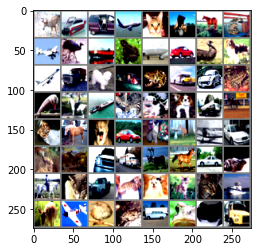

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer  ship   car plane   cat truck horse   cat plane  bird  ship  frog plane   car  bird   dog plane truck   dog   car  frog truck   car  frog  bird horse  ship   cat   cat   dog truck horse  frog horse   cat   car   cat  deer plane   car  deer  deer   car truck  deer horse   car  frog horse   cat truck   cat   dog   cat   cat  ship  deer plane  bird  frog   car  frog   cat truck
shape of the image:  torch.Size([3, 32, 32])


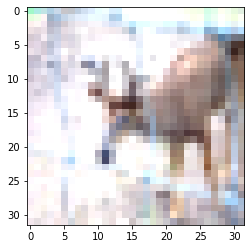

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    print("shape of the image: ", img.shape)
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# 학습용 이미지 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

imshow(images[0])

# 신경망 정의 (DenseNet) 사용하기


In [5]:
class bn_relu_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size, stride, padding, bias=False):
        super(bn_relu_conv, self).__init__()
        self.batch_norm = nn.BatchNorm2d(nin)
        self.relu = nn.ReLU(True)
        self.conv = nn.Conv2d(nin, nout, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)

    def forward(self, x):
        out = self.batch_norm(x)
        out = self.relu(out)
        out = self.conv(out)

        return out

class bottleneck_layer(nn.Sequential):
    def __init__(self, nin, growth_rate, drop_rate=0.2):    
        super(bottleneck_layer, self).__init__()
        self.add_module('conv_1x1', bn_relu_conv(nin=nin, nout=growth_rate*4, kernel_size=1, stride=1, padding=0, bias=False))
        self.add_module('conv_3x3', bn_relu_conv(nin=growth_rate*4, nout=growth_rate, kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = drop_rate
      
    def forward(self, x):
        bottleneck_output = super(bottleneck_layer, self).forward(x)
        if self.drop_rate > 0:
            bottleneck_output = F.dropout(bottleneck_output, p=self.drop_rate, training=self.training)
          
        bottleneck_output = torch.cat((x, bottleneck_output), 1)
      
        return bottleneck_output

    
class Transition_layer(nn.Sequential):
    def __init__(self, nin, theta=0.5):    
        super(Transition_layer, self).__init__()
      
        self.add_module('conv_1x1', bn_relu_conv(nin=nin, nout=int(nin*theta), kernel_size=1, stride=1, padding=0, bias=False))
        self.add_module('avg_pool_2x2', nn.AvgPool2d(kernel_size=2, stride=2, padding=0))
        
        
class DenseBlock(nn.Sequential):
    def __init__(self, nin, num_bottleneck_layers, growth_rate, drop_rate=0.2):
        super(DenseBlock, self).__init__()
                        
        for i in range(num_bottleneck_layers):
            nin_bottleneck_layer = nin + growth_rate * i
            self.add_module('bottleneck_layer_%d' % i, bottleneck_layer(nin=nin_bottleneck_layer, growth_rate=growth_rate, drop_rate=drop_rate))
            
            

class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, num_layers=40, theta=0.5, drop_rate=0.2, num_classes=10):
        super(DenseNet, self).__init__()
        
        assert (num_layers - 4) % 6 == 0
        
        # (num_layers-4)//6 
        num_bottleneck_layers = (num_layers - 4) // 6    # 16개
        
        # 32 x 32 x 3 --> 32 x 32 x (growth_rate*2)
        self.dense_init = nn.Conv2d(3, growth_rate*2, kernel_size=3, stride=1, padding=1, bias=True)
                
        # channel in : growth_rate*2 --> out : (growth_rate*2) + (growth_rate * num_bottleneck_layers)
        self.dense_block_1 = DenseBlock(nin=growth_rate*2, num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)

        # 32 x 32 x [(growth_rate*2) + (growth_rate * num_bottleneck_layers)] --> 16 x 16 x [(growth_rate*2) + (growth_rate * num_bottleneck_layers)]*theta
        nin_transition_layer_1 = (growth_rate*2) + (growth_rate * num_bottleneck_layers) 
        self.transition_layer_1 = Transition_layer(nin=nin_transition_layer_1, theta=theta)
        
        # 16 x 16 x nin_transition_layer_1*theta --> 16 x 16 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)]
        self.dense_block_2 = DenseBlock(nin=int(nin_transition_layer_1*theta), num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)

        # 16 x 16 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)] --> 8 x 8 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)]*theta
        nin_transition_layer_2 = int(nin_transition_layer_1*theta) + (growth_rate * num_bottleneck_layers) 
        self.transition_layer_2 = Transition_layer(nin=nin_transition_layer_2, theta=theta)
        
        # 8 x 8 x nin_transition_layer_2*theta --> 8 x 8 x [nin_transition_layer_2*theta + (growth_rate * num_bottleneck_layers)]
        self.dense_block_3 = DenseBlock(nin=int(nin_transition_layer_2*theta), num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)
        
        nin_fc_layer = int(nin_transition_layer_2*theta) + (growth_rate * num_bottleneck_layers) 
        
        # [nin_transition_layer_2*theta + (growth_rate * num_bottleneck_layers)] --> num_classes
        self.fc_layer = nn.Linear(nin_fc_layer, num_classes)
        
    def forward(self, x):
        dense_init_output = self.dense_init(x)
        
        dense_block_1_output = self.dense_block_1(dense_init_output)
        transition_layer_1_output = self.transition_layer_1(dense_block_1_output)
        
        dense_block_2_output = self.dense_block_2(transition_layer_1_output)
        transition_layer_2_output = self.transition_layer_2(dense_block_2_output)
        
        dense_block_3_output = self.dense_block_3(transition_layer_2_output)
        
        global_avg_pool_output = F.adaptive_avg_pool2d(dense_block_3_output, (1, 1))                
        global_avg_pool_output_flat = global_avg_pool_output.view(global_avg_pool_output.size(0), -1)

        output = self.fc_layer(global_avg_pool_output_flat)
        
        return output
    


In [6]:
def DenseNetBC_100_12():
    return DenseNet(growth_rate=12, num_layers=100, theta=0.5, drop_rate=0.2, num_classes=10)

In [7]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.device("cuda:0"))

True
GeForce RTX 2080 SUPER
cuda:0


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

net = DenseNetBC_100_12()
net.to(device)

cuda:0


DenseNet(
  (dense_init): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense_block_1): DenseBlock(
    (bottleneck_layer_0): bottleneck_layer(
      (conv_1x1): bn_relu_conv(
        (batch_norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (conv_3x3): bn_relu_conv(
        (batch_norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (bottleneck_layer_1): bottleneck_layer(
      (conv_1x1): bn_relu_conv(
        (batch_norm): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
   

In [9]:
import torchsummary
torchsummary.summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             672
       BatchNorm2d-2           [-1, 24, 32, 32]              48
              ReLU-3           [-1, 24, 32, 32]               0
            Conv2d-4           [-1, 48, 32, 32]           1,152
      bn_relu_conv-5           [-1, 48, 32, 32]               0
       BatchNorm2d-6           [-1, 48, 32, 32]              96
              ReLU-7           [-1, 48, 32, 32]               0
            Conv2d-8           [-1, 12, 32, 32]           5,184
      bn_relu_conv-9           [-1, 12, 32, 32]               0
      BatchNorm2d-10           [-1, 36, 32, 32]              72
             ReLU-11           [-1, 36, 32, 32]               0
           Conv2d-12           [-1, 48, 32, 32]           1,728
     bn_relu_conv-13           [-1, 48, 32, 32]               0
      BatchNorm2d-14           [-1, 48,

# 손실함수와 optimizer 정의하기

In [10]:
from torch.nn.modules import Module
from typing import Callable, Optional
from torch import Tensor
import torch.nn.functional as nn

class _Loss(Module):
    reduction: str

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction


class _WeightedLoss(_Loss):
    def __init__(self, weight: Optional[Tensor] = None, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_WeightedLoss, self).__init__(size_average, reduce, reduction)
        self.register_buffer('weight', weight)
        self.weight: Optional[Tensor]
            

class CrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight: Optional[Tensor] = None, size_average=None, ignore_index: int = -100,
                 reduce=None, reduction: str = 'mean') -> None:
        super(CrossEntropyLoss, self).__init__(weight, size_average, reduce, reduction)
        # self.ignore_index = ignore_index

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        def crossEntropyError(input, target):
            delta = 1e-7
           
            softmax = torch.nn.Softmax(dim=1)
            input = softmax(input)
            # print("input shape:", input.shape)
            target = F.one_hot(target, num_classes=10) # target을 원-핫 벡터로 바꾸어주어야 한다. (64, 10)
            # print("target shape:", target.shape)
            return -torch.sum(target*torch.log(input+delta))
        
        # return F.cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index, reduction=self.reduction)
        return crossEntropyError(input, target)


### torch.nn.CrossEntropyLoss() 와 직접 작성한 크로스엔트로피 둘 다 동작함
### 이유는 모르겠으나, 직접 작성한 Loss를 사용했을 때 accuracy 가 더 빠르게 올라감

In [11]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
criterion = CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 학습하기
* 학습 1. DenseNet Layer = 100 batch 64
* 학습 2. DenseNet Layer = 40  batch 64

In [12]:
from tqdm import tqdm

loss_list = []
for epoch in range(100):
    
    running_loss = 0.0
    
    for i, data in tqdm(enumerate(train_loader, 0)):
        #print(i)
        #print(len(train_loader))
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
#         print(len(inputs))
#         print(len(labels))
        
        # gradient 매개변수를 0으로 만든다.
        optimizer.zero_grad()
        
        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            print('[%d, %5d] loss: %3f' % (epoch + 1, i + 1, running_loss / 100))
            loss_list.append(running_loss / 100)
            running_loss = 0.0
            
    # validation part
    correct = 0
    total = 0
    for i, data in tqdm(enumerate(valid_loader, 0)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('[%d epoch] Accuracy of the network on the validation images: %d %%' % 
          (epoch + 1, 100 * correct / total))
    
print("학습 끝")

101it [00:11,  8.70it/s]

[1,   100] loss: 123.996718


201it [00:23,  8.51it/s]

[1,   200] loss: 107.814204


301it [00:34,  8.74it/s]

[1,   300] loss: 101.698838


401it [00:46,  8.75it/s]

[1,   400] loss: 95.527100


501it [00:57,  8.76it/s]

[1,   500] loss: 86.707415


601it [01:09,  8.75it/s]

[1,   600] loss: 85.074012


701it [01:20,  8.76it/s]

[1,   700] loss: 77.636464


704it [01:21,  8.68it/s]
79it [00:03, 24.49it/s]
1it [00:00,  6.76it/s]

[1 epoch] Accuracy of the network on the validation images: 51 %


101it [00:11,  8.63it/s]

[2,   100] loss: 72.792475


201it [00:23,  8.58it/s]

[2,   200] loss: 71.461650


301it [00:34,  8.70it/s]

[2,   300] loss: 71.126410


401it [00:46,  8.69it/s]

[2,   400] loss: 64.714122


501it [00:57,  8.63it/s]

[2,   500] loss: 62.950268


601it [01:09,  8.69it/s]

[2,   600] loss: 63.822713


701it [01:21,  8.57it/s]

[2,   700] loss: 60.294611


704it [01:21,  8.65it/s]
79it [00:03, 25.17it/s]
1it [00:00,  5.36it/s]

[2 epoch] Accuracy of the network on the validation images: 66 %


101it [00:11,  8.71it/s]

[3,   100] loss: 56.092211


201it [00:23,  8.72it/s]

[3,   200] loss: 58.014473


301it [00:34,  8.56it/s]

[3,   300] loss: 52.623132


401it [00:46,  8.41it/s]

[3,   400] loss: 52.965673


501it [00:58,  8.41it/s]

[3,   500] loss: 52.281391


601it [01:10,  8.43it/s]

[3,   600] loss: 50.721355


701it [01:22,  8.12it/s]

[3,   700] loss: 48.745160


704it [01:22,  8.52it/s]
79it [00:03, 24.21it/s]
1it [00:00,  6.62it/s]

[3 epoch] Accuracy of the network on the validation images: 73 %


101it [00:12,  8.30it/s]

[4,   100] loss: 45.751555


201it [00:24,  8.42it/s]

[4,   200] loss: 44.098998


301it [00:36,  8.63it/s]

[4,   300] loss: 44.480312


401it [00:47,  8.25it/s]

[4,   400] loss: 43.538472


501it [00:59,  8.46it/s]

[4,   500] loss: 43.668472


601it [01:11,  8.36it/s]

[4,   600] loss: 41.717703


701it [01:23,  8.62it/s]

[4,   700] loss: 42.071970


704it [01:23,  8.39it/s]
79it [00:03, 24.83it/s]
0it [00:00, ?it/s]

[4 epoch] Accuracy of the network on the validation images: 73 %


101it [00:11,  8.74it/s]

[5,   100] loss: 37.941212


201it [00:23,  8.67it/s]

[5,   200] loss: 37.334130


301it [00:34,  8.58it/s]

[5,   300] loss: 39.848814


401it [00:46,  8.51it/s]

[5,   400] loss: 37.508006


501it [00:58,  8.50it/s]

[5,   500] loss: 36.798779


601it [01:10,  8.71it/s]

[5,   600] loss: 36.256785


701it [01:21,  8.62it/s]

[5,   700] loss: 35.669282


704it [01:22,  8.57it/s]
79it [00:03, 24.54it/s]
1it [00:00,  6.71it/s]

[5 epoch] Accuracy of the network on the validation images: 78 %


101it [00:11,  8.49it/s]

[6,   100] loss: 31.817118


201it [00:23,  8.55it/s]

[6,   200] loss: 33.083161


301it [00:35,  8.58it/s]

[6,   300] loss: 31.976101


401it [00:47,  8.51it/s]

[6,   400] loss: 32.032665


501it [00:58,  8.60it/s]

[6,   500] loss: 33.339393


601it [01:10,  8.35it/s]

[6,   600] loss: 32.661037


701it [01:22,  8.56it/s]

[6,   700] loss: 31.724573


704it [01:22,  8.50it/s]
79it [00:03, 24.80it/s]
1it [00:00,  5.39it/s]

[6 epoch] Accuracy of the network on the validation images: 79 %


101it [00:12,  8.63it/s]

[7,   100] loss: 28.921833


201it [00:23,  8.15it/s]

[7,   200] loss: 29.118563


301it [00:35,  8.21it/s]

[7,   300] loss: 29.754646


401it [00:47,  8.68it/s]

[7,   400] loss: 30.359238


501it [00:59,  8.26it/s]

[7,   500] loss: 29.364256


601it [01:11,  8.60it/s]

[7,   600] loss: 29.616800


634it [01:15,  8.45it/s]


KeyboardInterrupt: 

# 학습한 모델 저장하기

In [ ]:
PATH = './cifar_net.pth'

torch.save(net.state_dict(), PATH)

# 테스트 데이터로 신경망 검사하기

In [ ]:
dataiter = iter(test_loader)

images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 지정했던 모델 불러오기

In [ ]:
net = DenseNetBC_100_12()
net.load_state_dict(torch.load(PATH))

# 신경망의 예측값 확인하기

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

In [ ]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4) ))

In [ ]:
correct = 0
total = 0

# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없다.
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
    print('Accuracy of the network on the 10000 test images : %d %%' % (100 * correct / total))

# 클래스 별 정확도 확인하기

In [ ]:
print(classes)

In [ ]:
# 각 분류에 대한 예측값 계산

correct_pred = {classname : 0 for classname in classes}
total_pred = {classname : 0 for classname in classes}

# 변화도는 test중이므로 필요하지 않음

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        
        # 각 분류별로 올바른 예측 수를 모읍니다.
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
    
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))